In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

In [2]:
import pg8000
conn = pg8000.connect(host='training.c1erymiua9dx.us-east-1.rds.amazonaws.com', database="training", port=5432, user='dot_student', password='qgis')
cursor = conn.cursor()

In [3]:
# Getting the column names
statement = "select * from INFORMATION_SCHEMA.COLUMNS where table_name = 'dot_311'"
cursor.execute(statement)
columns = []
for row in cursor.fetchall():
    columns.append(row[3])
print(*columns)

gid unique_key agency agency nam complaint descriptor location t incident z incident a street nam cross stre cross st_1 intersecti intersec_1 address ty city landmark facility t status due date resolution resoluti_1 community borough x coordina y coordina park facil park borou school nam school num school reg school cod school pho school add school cit school sta school zip school not school or vehicle ty taxi compa taxi pick bridge hig bridge h_1 road ramp bridge h_2 garage lot ferry dire ferry term latitude longitude location geom created_date closed_date


In [4]:
statement = "SELECT unique_key, complaint, created_date, closed_date FROM dot_311"
cursor.execute(statement)
complaints = []
for row in cursor:
    complaints.append(row)

In [5]:
for complaint in complaints:
    try:
        complaint.append(complaint[3] - complaint[2])
    except:
        complaint.append(None)

In [6]:
df = pd.DataFrame(complaints)
df.columns = ['key', 'complaint', 'created_date', 'closed_date', 'time']

In [7]:
df.describe()

,key,complaint,created_date,closed_date,time
count,5851,5851,5851,5650,5650
unique,5851,20,4753,3950,NaN
top,32607302,Street Light Condition,2016-02-03 07:00:00,2016-02-03 22:00:00,NaN
freq,1,2040,29,122,NaN
first,NaN,NaN,2016-02-01 00:06:44,2016-01-15 00:05:00,NaN
last,NaN,NaN,2016-02-07 00:00:00,2016-05-02 11:02:00,NaN
mean,NaN,NaN,NaN,NaN,6 days 15:05:05.589380
std,NaN,NaN,NaN,NaN,14 days 12:05:38.260805
min,NaN,NaN,NaN,NaN,-19 days +09:29:00
25%,NaN,NaN,NaN,NaN,0 days 01:14:00


In [8]:
from datetime import timedelta
from math import nan

no_delta_count = 0

def delta_to_seconds(delta):
    if not isinstance(delta, timedelta):
        global no_delta_count
        no_delta_count = no_delta_count + 1
        return nan
    else:
        return timedelta.total_seconds(delta)

    
df['time_seconds'] = df['time'].apply(delta_to_seconds)

print(no_delta_count, "values out of", len(df), "weren't time deltas.")

201 values out of 5851 weren't time deltas.


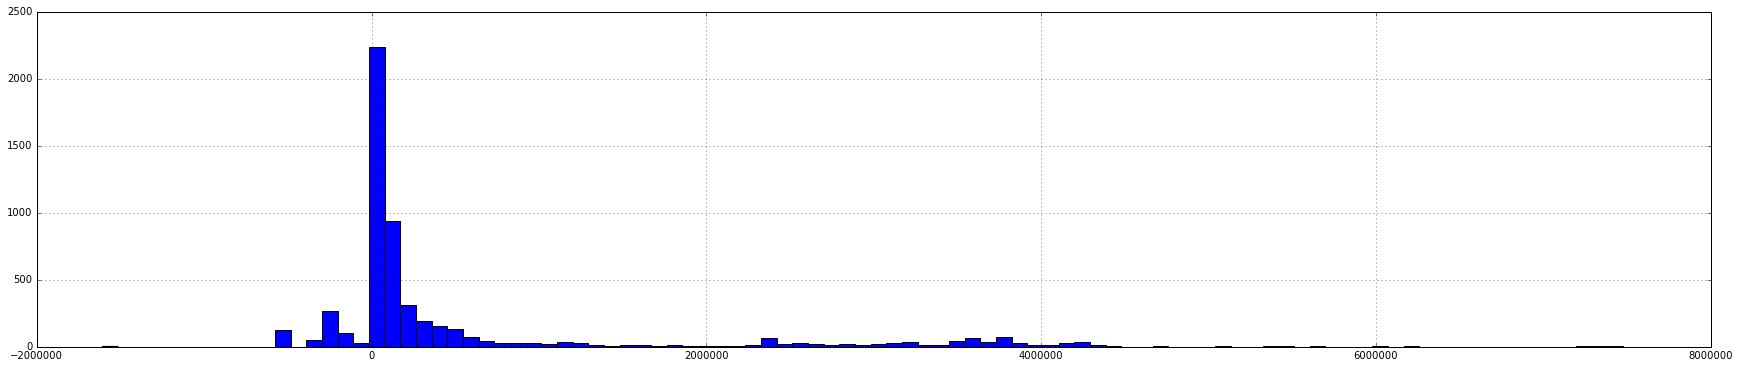

In [9]:
df['time_seconds'].hist(bins=100, figsize=(30, 6))

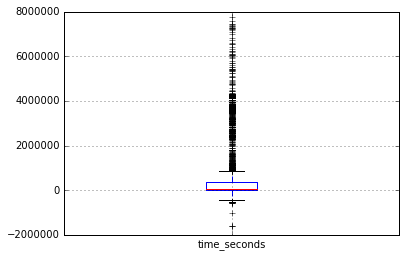

In [10]:
df[['time_seconds']].boxplot(return_type='axes')

In [11]:
# The record time is 89 days
df.iloc[df[['time_seconds']].idxmax()]

,key,complaint,created_date,closed_date,time,time_seconds
1743,32591202,Street Light Condition,2016-02-02 16:08:00,2016-05-02 11:02:00,89 days 18:54:00,7757640.0


In [12]:
# And one request was recorded as closed 19 days *before* being created
df.iloc[df[['time_seconds']].idxmin()]

,key,complaint,created_date,closed_date,time,time_seconds
1625,32585502,Street Light Condition,2016-02-02 14:36:00,2016-01-15 00:05:00,-19 days +09:29:00,-1607460.0


In [13]:
# We'll now study the appropriate times
df_positive_time = df[df['time_seconds'] > 0]
df_positive_time.shape

(4547, 6)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1168fa2e8>]], dtype=object)

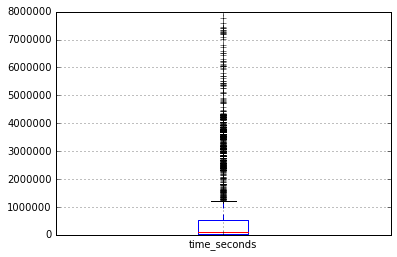

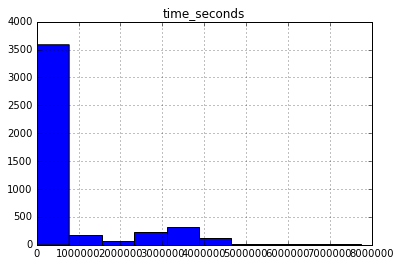

In [14]:
df_positive_time.boxplot(return_type='axes')
df_positive_time.hist()

In [15]:
df_less_11_days = df_positive_time[df_positive_time['time_seconds'] < 1000000]
df_more_11_days = df[df['time_seconds'] > 1000000]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116b6b828>]], dtype=object)

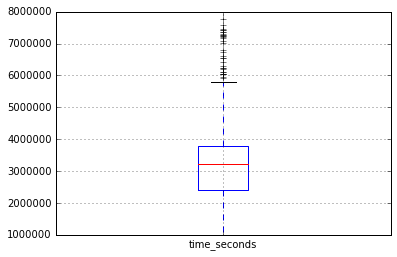

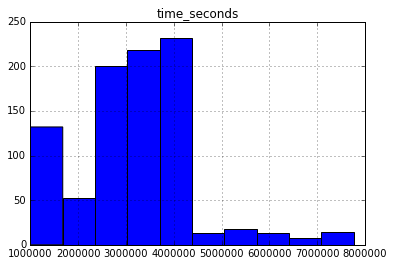

In [16]:
df_more_11_days.boxplot(return_type='axes')
df_more_11_days.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116dcdef0>]], dtype=object)

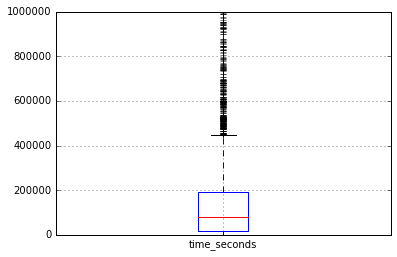

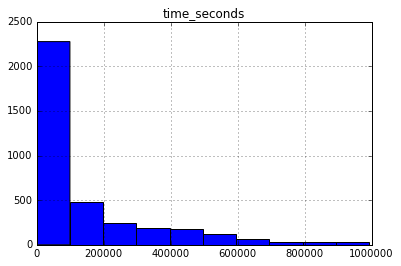

In [17]:
df_less_11_days.boxplot(return_type='axes')
df_less_11_days.hist()

In [18]:
df_no_nan = df[df['time_seconds'] == df['time_seconds']]
iqr = df_no_nan['time_seconds'].quantile(q=0.75) - df_no_nan['time_seconds'].quantile(q=0.25)
print("The interquartile is", iqr, "seconds.")
print("Which is:", df['time'].quantile(q=0.75) - df['time'].quantile(q=0.25))
print("The standard deviation is", df['time'].std())

The interquartile is 343008.5 seconds.
Which is: 3 days 23:16:48.500000
The standard deviation is 14 days 12:05:38.260805


In [19]:
def set_timeframe(time_seconds):
    if time_seconds < 0:
        return 'Negative'
    elif time_seconds == 0:
        return 'Zero'
    elif time_seconds < 604800:
        return 'Less than a week'
    elif time_seconds >= 604800:
        return 'More than a week'
    else:
        return 'Undefined'
    
df['timeframe'] = df['time_seconds'].apply(set_timeframe)

In [20]:
df['timeframe'].value_counts()

Less than a week    3499
More than a week    1048
Negative             582
Zero                 521
Undefined            201
Name: timeframe, dtype: int64

In [21]:
print("Top complaints per timeframe:")
df.groupby('timeframe')['complaint'].value_counts()

Top complaints per timeframe:


timeframe         complaint                 
Less than a week  Street Condition              1640
                  Traffic Signal Condition       762
                  Street Light Condition         739
                  Sidewalk Condition              86
                  Highway Condition               67
                  Street Sign - Damaged           42
                  Street Sign - Missing           33
                  DOT Literature Request          31
                  Street Sign - Dangling          30
                  Curb Condition                  17
                  Bridge Condition                14
                  Ferry Inquiry                   13
                  Broken Muni Meter               12
                  Bus Stop Shelter Placement       6
                  Ferry Complaint                  4
                  Public Toilet                    2
                  Highway Sign - Damaged           1
More than a week  Broken Muni Meter              513
 

timeframe
Less than a week    [[Axes(0.125,0.125;0.775x0.775)]]
More than a week    [[Axes(0.125,0.125;0.775x0.775)]]
Negative            [[Axes(0.125,0.125;0.775x0.775)]]
Undefined           [[Axes(0.125,0.125;0.775x0.775)]]
Zero                [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

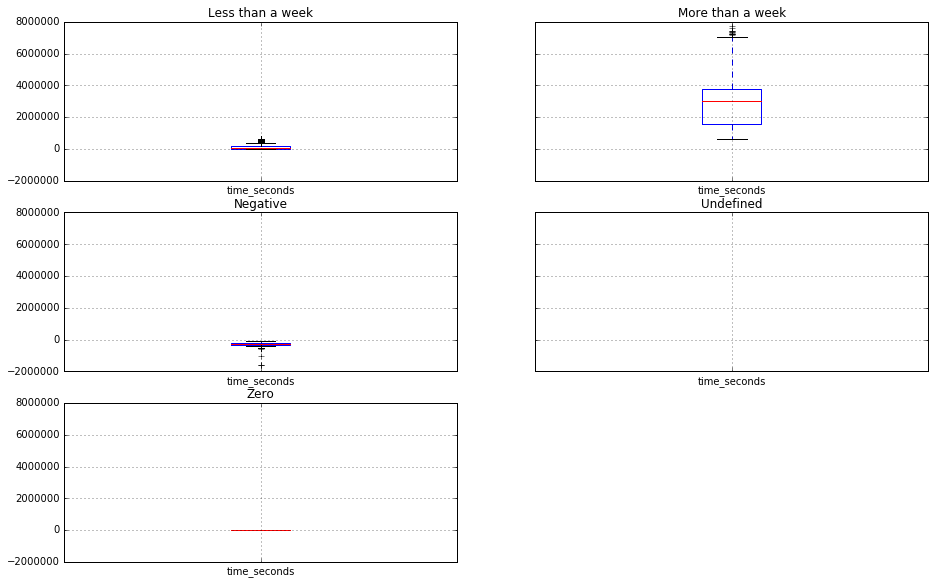

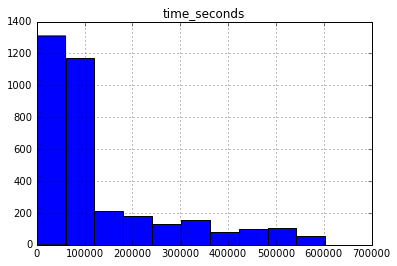

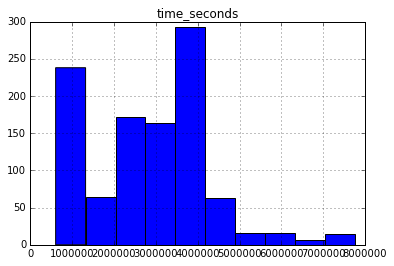

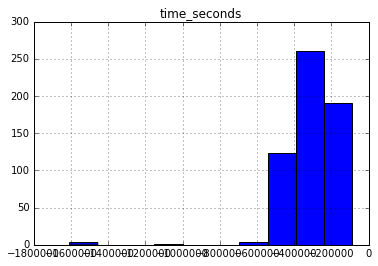

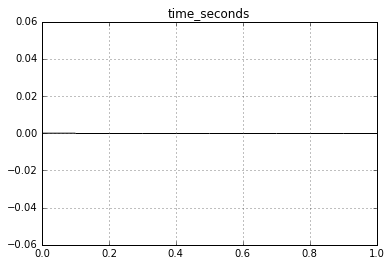

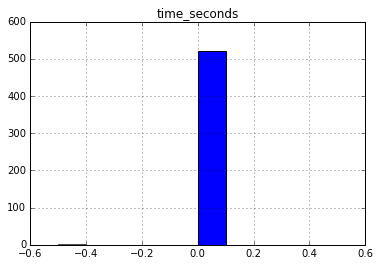

In [23]:
# Let's have a closer look at these four groups

df.groupby('timeframe').boxplot(figsize=(15, 10), return_type='axes')
df.groupby('timeframe').hist()

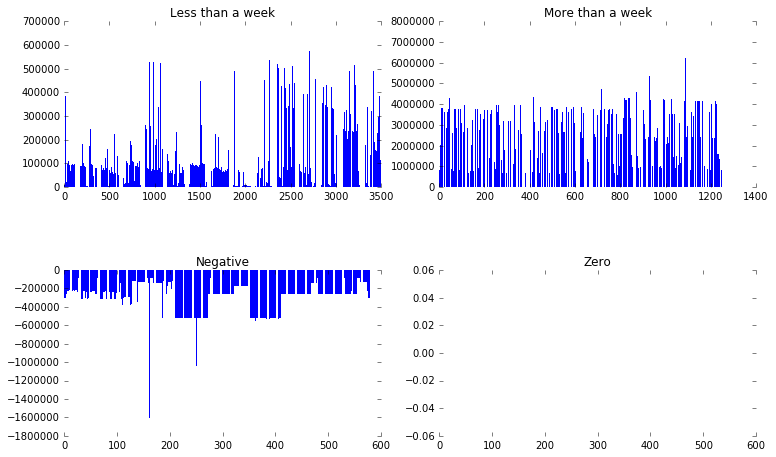

In [22]:
# Fun with small multiples!

category = 'timeframe'
categories = df[category].unique().tolist()

nrows = 2; ncols = 2
num_plots = nrows * ncols  # number of subplots

fig = plt.figure(figsize=(10, 6))

axes = [plt.subplot(nrows,ncols,i) for i in range(1,num_plots+1)]

plt.tight_layout(pad=0, w_pad=3, h_pad=1)
plt.subplots_adjust(hspace=.5)


for i in range(num_plots):
    ax = axes[i]
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    dfx = df[df[category]==categories[i]]#.head(5)
    
#   BAR CHARTS
    x = dfx['complaint']
    y = dfx['time_seconds']
    ax.set_title(categories[i])
    ax.bar(left=range(0, len(dfx)), height=dfx['time_seconds'], linewidth=0)    
